# Tarea 4: Psicrometría
### Pablo Correa e Ian Gross

## Librerías

In [2]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
import scipy.constants as cte
import scipy.optimize as opt
import matplotlib.pyplot as plt

from fluids.units import *

from PIL import Image

In [3]:
g = cte.g*u.m/u.s**2
Patm = (1*u.atm).to(u.Pa)

# Pregunta 1
Un flujo de aire (corriente 1) a 60°F , 1 atm y 30 % de humedad relativa se mezcla adiabáticamente
con un flujo de aire (corriente 2) a 90°F , 1 atm y 80 % de humedad relativa. Una sola corriente (corriente
3) sale de la cámara de mezcla a una temperatura T3 y 1 atm. Suponga un estado estacionario e ignore
los efectos de energía cinética y potencial. Sea r la relación de los caudales másicos de aire seco  ̇$\dot{m}_{a,1}/\dot{m}_{a,2}$:

(a) (3 pts) Determine T3, en ◦C, para r = 2.

(b) (3 pts) Ilustre el proceso de mezcla en un diagrama psicrométrico.

(c) (3 pts) Construya un gráfico de T3 versus r, variando r de 0 a 10.

## Parte A

In [4]:
T_1 = (60*u.fahrenheit).to(u.kelvin)
T_2 = (90*u.fahrenheit).to(u.kelvin)
HR_1 = 0.3
HR_2 = 0.8

P = Patm
r = 2

Utilizando la humedad relativa, se obtiene la humedad absoluta y la entalpía específica para las corrientes de entrada (1 y 2)

In [5]:
w_1 = cp.HAPropsSI('W', 'T', T_1.magnitude, 'R', HR_1, 'P', P.magnitude)
h_1 = cp.HAPropsSI('H', 'T', T_1.magnitude, 'R', HR_1, 'P', P.magnitude)*u.joule/u.kilogram

w_2 = cp.HAPropsSI('W', 'T', T_2.magnitude, 'R', HR_2, 'P', P.magnitude)
h_2 = cp.HAPropsSI('H', 'T', T_2.magnitude, 'R', HR_2, 'P', P.magnitude)*u.joule/u.kilogram

Las ecuaciones de balance de masa, masa humeda y energía para el caso de mezcla adiabática son

$$\dot{m}_1 + \dot{m}_2 = \dot{m}_3$$

$$\dot{m}_1 \omega_1 + \dot{m}_2 \omega_2 = \dot{m}_3 \omega_3$$

$$\dot{m}_1 h_1 + \dot{m}_2 h_2 = \dot{m}_3 h_3$$

Dada la definición de $r$ y el balance de masas se tiene que

$$\dot{m}_1 = r \dot{m}_2$$

$$\dot{m}_3 = (1 + r)\dot{m}_2$$

Con estos resultados se tiene que la humedad absoluta y entalpía específica de salida serían

$$\omega_3 = \frac{r \omega_1 + \omega_2}{r + 1}$$

$$h_3 = \frac{r h_1 + h_2}{r + 1}$$

In [6]:
def corriente_3(corriente_1, corriente_2, r):
    value = (r*corriente_1 + corriente_2)/(r+1)
    return value

w_3 = corriente_3(w_1, w_2, r)
h_3 = corriente_3(h_1, h_2, r)

Luego, utilizando la humedad específica y la entalpía específica en la corriente 3, se puede utilizar CoolProp para obtener la temperatura correspondiente en la corriente 3.

In [12]:
T_3 = cp.HAPropsSI('T', 'W', w_3, 'H', h_3.magnitude, 'P', P.magnitude)

T_3 = (T_3*u.kelvin).to(u.celsius)
T_3

<Quantity(21.2527681, 'degree_Celsius')>

## Parte B

## Parte C

Aplicando la solución para la parte (a), se resuelve y se grafica la temperatura en la corriente 3 en relación a la razón $r$.

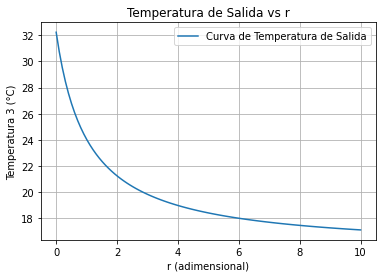

In [22]:
def Temp_3(w_1, w_2, h_1, h_2, r):
    w_3 = corriente_3(w_1, w_2, r)
    h_3 = corriente_3(h_1, h_2, r)
    T_3 = cp.HAPropsSI('T', 'W', w_3, 'H', h_3.magnitude, 'P', P.magnitude)*u.kelvin

    return T_3.to(u.celsius)

r_range = np.linspace(0,10,100)

T_3_range = [Temp_3(w_1, w_2, h_1, h_2, r_range[i]).magnitude for i in range(100)]

# plot curva de sistema
plt.plot(r_range, T_3_range, label='Curva de Temperatura de Salida')

# aspectos visuales
plt.xlabel('r (adimensional)')
plt.ylabel('Temperatura 3 (°C)')
plt.title('Temperatura de Salida vs r')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 2
Se debe suministrar, en estado estacionario, aire húmedo a una sala de clases a una tasa de flujo
volumétrico y temperatura T especificadas. El aire es retirado de la sala en una corriente diferente que
se encuentra a una temperatura de 27°C y 50 % de humedad relativa. Se agrega humedad al aire en
la habitación desde los ocupantes a una tasa de 4,5 kg/h. La humedad puede considerarse como vapor
saturado a 33°C. La transferencia de calor al espacio ocupado desde todas las fuentes se estima en
34,000 kJ/h. La presión permanece uniforme en 1 atm.

(a) (3 pts) Para una tasa de flujo volumétrico de aire suministrado de 40 m3/min, determine la
temperatura del aire suministrado T , en °C, y la humedad relativa.

(b) (3 pts) Ilustre el proceso de mezcla en un diagrama psicrométrico.

(c) (3 pts) Construya un gráfico de la temperatura del aire suministrado, en °C , y la humedad
relativa,ambas vs la tasa de flujo volumétrico de aire suministrado, variando esta última de 35 a
90 m3/min.

## Parte A

In [22]:
T_out = 27*u.celsius
HR_out = 0.5

m_v_in = (4.5*u.kg/u.hour).to(u.kg/u.s)
T_v = 33*u.celsius
q_in = (34000*u.kJ/u.h).to(u.W)

P = Patm
flow_rates_in = 40*u.m**3/u.min

## Parte B

## Parte C

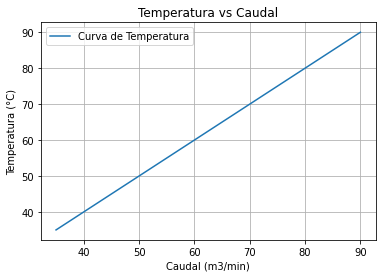

In [9]:
flow_rates = np.linspace(35,90,100)

# plot curva de sistema
plt.plot(flow_rates, flow_rates, label='Curva de Temperatura')

# aspectos visuales
plt.xlabel('Caudal (m3/min)')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura vs Caudal')
plt.legend()
plt.grid(True)
plt.show()

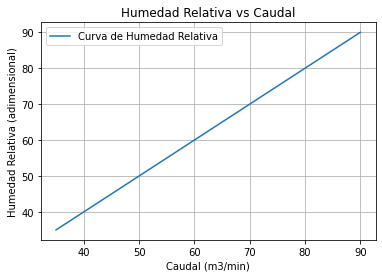

In [10]:
flow_rates = np.linspace(35,90,100)

# plot curva de sistema
plt.plot(flow_rates, flow_rates, label='Curva de Humedad Relativa')

# aspectos visuales
plt.xlabel('Caudal (m3/min)')
plt.ylabel('Humedad Relativa (adimensional)')
plt.title('Humedad Relativa vs Caudal')
plt.legend()
plt.grid(True)
plt.show()

# Pregunta 3
Considere los datos de la instalación de APR en Hualañé, incluyendo la distribución de diámetros y
la bomba seleccionada en las entregas anteriores.

a) (3pts) Verique el pñunto de operación y si se cumple la jnormativa, en el escenario que 3 nuevas
vivuiendas sean construídas en el sector más alto de Hualañé.

b) (3pts) Sugiera una solución a la situación anteior, para asegurar el suministro bajo las normas de
servicios sanitarios.

# Bibliografía

[1] https://www.stainless-structurals.com/blog/comparing-the-thermal-conductivity-of-stainless-steel-to-other-metals/